In [377]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue, LifoQueue as Stack
from typing import Literal
import numpy as np
from time import time
import sys
np.set_printoptions(threshold=sys.maxsize)

# Algorihtms code

In [555]:
SEARCH_MODE = Literal['DFS', 'BFS']

def search(capacity, source, sink, mode: SEARCH_MODE):
    traverse = [-1] * len(capacity)
    to_visit = Queue() if mode == 'BFS' else Stack()
    to_visit.put(source)
    
    if source == sink:
        return traverse
    
    while not to_visit.empty():
        u = to_visit.get()
        for v in range(len(capacity)):
            if capacity[u, v] > 0 and traverse[v] == -1:
                traverse[v] = u
                if v == sink:
                    return traverse
                to_visit.put(v)
                
    return traverse

def Ford_Fulkerson(capacity, source=0, sink=None, mode: SEARCH_MODE = 'DFS', simulate = False):
    capacity = np.array(capacity)
    max_flow = 0
    if sink == None:
        sink = len(capacity) - 1
    simulate_data = [[]]

    while True:
        path_flow = float('inf')
        traverse = search(capacity, source, sink, mode)
        if traverse[sink] == -1:
            break
        
        curr = sink
        while curr != source:
            if simulate:
                simulate_data[-1].append(curr)
            prev = traverse[curr]
            path_flow = min(path_flow, capacity[prev, curr])
            curr = prev

        curr = sink
        while curr != source :
            prev = traverse[curr]
            capacity[prev, curr] -= path_flow
            capacity[curr, prev] += path_flow
            curr = prev
            
        max_flow += path_flow
        if simulate:
            simulate_data[-1] = [0] + simulate_data[-1][::-1] + [int(path_flow)]
            simulate_data.append([])
    if simulate:
        return max_flow, simulate_data
    return max_flow

def EdmondKarp(capacity: np.ndarray, source=0, sink=None, simulate = False):
    return Ford_Fulkerson(capacity, source, sink, 'BFS', simulate=simulate)

def BFS_using_levels(capacity, source, sink):
    level = [-1] * len(capacity)
    level[source] = 0

    to_visit = Queue()
    to_visit.put(source)

    while not to_visit.empty():
        current = to_visit.get()
        for successor in range(len(capacity)):
            if capacity[current, successor] > 0 and level[successor] < 0:
                level[successor] = level[current] + 1
                to_visit.put(successor)

    return level

def send_flow(capacity, source, sink, level, max_flow=float('inf'), simulate=False):
    if source == sink:
        return max_flow, []
    simulate_data = []
    for successor in range(len(capacity)):
        if (capacity[source, successor] > 0) and (level[source] + 1 == level[successor]):
            current_flow = min(max_flow, capacity[source, successor])
            if simulate:
                path_flow, simulate_data_ = send_flow(capacity, successor, sink, level, current_flow, simulate=simulate)
                if len(simulate_data_) != 0:
                    simulate_data = simulate_data_
                if path_flow > 0:        
                    capacity[source, successor] -= path_flow
                    capacity[successor, source] += path_flow
                    return path_flow, [source] + simulate_data
                
            else:
                path_flow = send_flow(capacity, successor, sink, level, current_flow, simulate=simulate)
                if path_flow > 0:        
                    capacity[source, successor] -= path_flow
                    capacity[successor, source] += path_flow
                    return path_flow
    if simulate:
        return 0, [source] + simulate_data
    return 0

def Dinic(capacity: np.ndarray, source=0, sink=None, simulate=False):
    capacity = np.array(capacity)
    max_flow = 0
    if sink is None:
        sink = len(capacity) - 1

    simulate_data = []
    
    while True:
        level = BFS_using_levels(capacity, source, sink)
        if level[sink] < 0:
            break

        while True:
            if simulate:
                path_flow, data = send_flow(capacity, source, sink, level, simulate=simulate)
                simulate_data.append(np.array(capacity))
                if path_flow == 0:
                    break
            else:
                path_flow = send_flow(capacity, source, sink, level, simulate=simulate)
                if path_flow == 0:
                    break

            max_flow += path_flow
    if simulate:
        return max_flow, simulate_data[:-1]
    return max_flow

# Compare performance

In [204]:
# Small sample
sample = np.array([ [0, 10, 0, 8, 0, 0],
                    [0, 0, 5, 2, 0, 0],
                    [0, 0, 0, 0, 0, 7],
                    [0, 0, 0, 0, 10, 0],
                    [0, 0, 8, 0, 0, 10],
                    [0, 0, 0, 0, 0, 0]])


start = time()
print(Ford_Fulkerson(sample))
print(time() - start)
start = time()
print(EdmondKarp(sample))
print(time() - start)
start = time()
print(Dinic(sample))
print(time() - start)

15
0.0018215179443359375
15
0.0017535686492919922
15
0.00174713134765625


In [484]:
# Large sample
from data import data_sample
print(data_sample.shape)

start = time()
max_flow = Ford_Fulkerson(data_sample)
run_time = time() - start
print(f"Ford_Fulkerson found max flow: {max_flow} with time {run_time}")

start = time()
max_flow = EdmondKarp(data_sample)
run_time = time() - start
print(f"EdmondKarp found max flow: {max_flow} with time {run_time}")

start = time()
max_flow = Dinic(data_sample)
run_time = time() - start
print(f"Dinic found max flow: {max_flow} with time {run_time}")

(1000, 1000)
Ford_Fulkerson found max flow: 180.0 with time 6.26483416557312
EdmondKarp found max flow: 180.0 with time 2.0769152641296387
Dinic found max flow: 180.0 with time 3.9139137268066406


# Demo

In [558]:
def generate_random_dag_max_flow_graph(n_nodes, n_edges, fig_width, min_capacity=10,  max_capacity=50, order=True):    
    # Generate pos in graph
    pos = dict()
    len_rows = [1] * int(np.sqrt(n_nodes)) * 2
    while sum(len_rows) != n_nodes:
        len_rows[np.random.randint(1, len(len_rows) - 1)] += 1
        
    node = 0
    rows = [[] for _ in range(len(len_rows))] 
    for row, len_row in enumerate(len_rows):
        for col in range(len_row):
            id_node = n_nodes - node - 1

            if len_row == 1:
                col = fig_width // 2
            else:
                col = (len_row - col - 1) * fig_width / (len_row - 1) + 1 * (1 if row % 2 else - 1)
                
            rows[row].append(id_node)
            pos[id_node] = (col, row)
            node += 1
    rows = [row[::-1] for row in rows[::-1]]
    
    # Generate graph
    G = nx.DiGraph()
    G.add_nodes_from(range(n_nodes))
    
    if order:
        while G.number_of_edges() < n_edges:
            row_u, row_v = sorted(np.random.choice(len(rows), size=2, replace=False))
            u = np.random.choice(rows[row_u])
            v = np.random.choice(rows[row_v])
            G.add_edge(u, v)
    else:
        while G.number_of_edges() < n_edges:
            source, target = np.random.choice(n_nodes, size=2, replace=False)
            if target == 0 or source == n_nodes - 1:
                continue
            if not nx.has_path(G, target, source):  # Ensure acyclicity
                G.add_edge(source, target)
            
    for i in range(1, len(rows) - 1):
        for node in rows[i]:
            if len(G.in_edges(node)) == 0:
                u = np.random.choice(rows[i-1])
                G.add_edge(u, node)
            if len(G.out_edges(node)) == 0:
                v = np.random.choice(rows[i+1])
                G.add_edge(node, v)
                
    for edge in G.edges:
        G[edge[0]][edge[1]]['capacity'] = np.random.randint(min_capacity, max_capacity + 1)  # Random capacity for the edge    
            
    return G, pos

def plot_graph(graph, pos, width, height):
    plt.figure(figsize=(width, height))
    edge_labels = nx.get_edge_attributes(graph, 'capacity')
    
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    nx.draw(graph, pos=pos, with_labels=True, arrowsize=10, node_size=200, node_color="skyblue", font_size=8, font_color="black")

    plt.show()
    
def simulate(graph, pos, simulate_data, width, height):
    edge_labels = nx.get_edge_attributes(graph, 'capacity')
    flow_dict = {(u, v): 0 for (u, v), c in edge_labels.items()}
    for data in simulate_data:
        plt.figure(figsize=(width, height))
        nx.draw(graph, pos=pos, with_labels=True, arrowsize=10, node_size=200, node_color="skyblue", font_size=8, font_color="black")
        for i in range(len(data)-2):
            u, v = data[i], data[i+1]
            flow_dict[(u, v)] += data[-1]
        edge_labels_ = {(u, v): f'{flow_dict[(u, v)]}/{c}' for (u, v), c in edge_labels.items()}
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels_)
        nx.draw_networkx_edges(graph, pos, edgelist=[(data[i], data[i+1]) for i in range(len(data)-2)], edge_color='red', width=2)
        
        plt.show()

def simulate_dinic(graph, pos, simulate_data, width, height):
    edge_labels = nx.get_edge_attributes(graph, 'capacity')
    for data in simulate_data:
        plt.figure(figsize=(width, height))
        nx.draw(graph, pos=pos, with_labels=True, arrowsize=10, node_size=200, node_color="skyblue", font_size=8, font_color="black")
        edge_labels_ = {(u, v): f'{c-data[(u, v)]}/{c}' for (u, v), c in edge_labels.items()}
        nx.draw_networkx_edge_labels(data, pos, edge_labels=edge_labels_)
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v) for (u, v), c in edge_labels.items() if data[(u, v)]!=c], edge_color='red', width=2)
        plt.show()

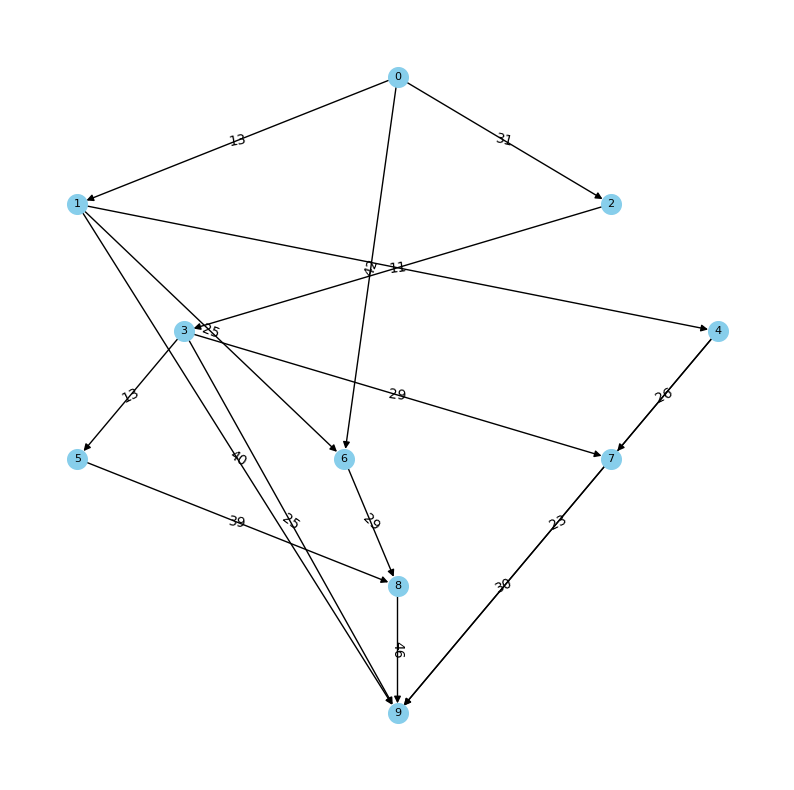

In [572]:
width = 10
height = 10
graph, pos = generate_random_dag_max_flow_graph(n_nodes=10, n_edges=10, fig_width=width, order=True)
adjacency_matrix = nx.attr_matrix(graph, edge_attr='capacity', rc_order=graph.nodes())
plot_graph(graph=graph, pos=pos, width=width, height=height)

Dinic found max flow: 53.0 with time 0.0006101131439208984


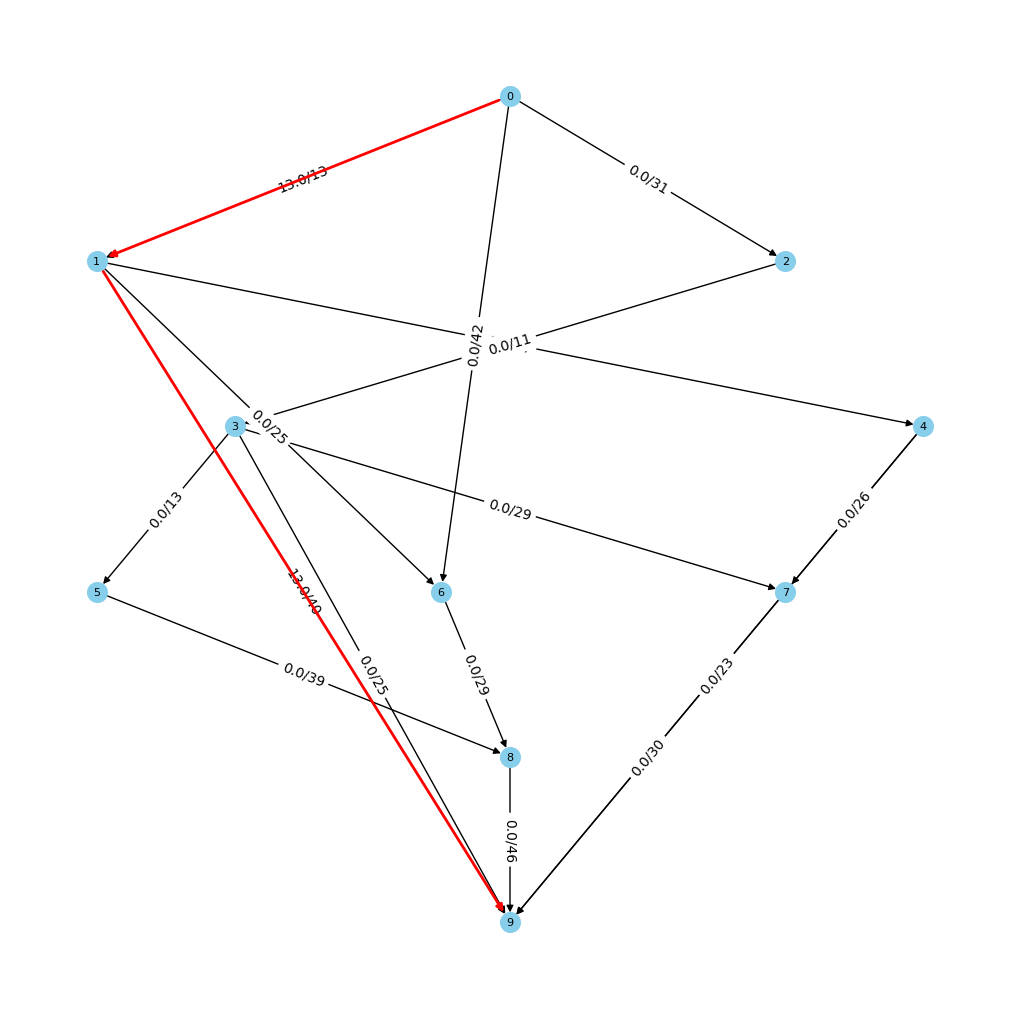

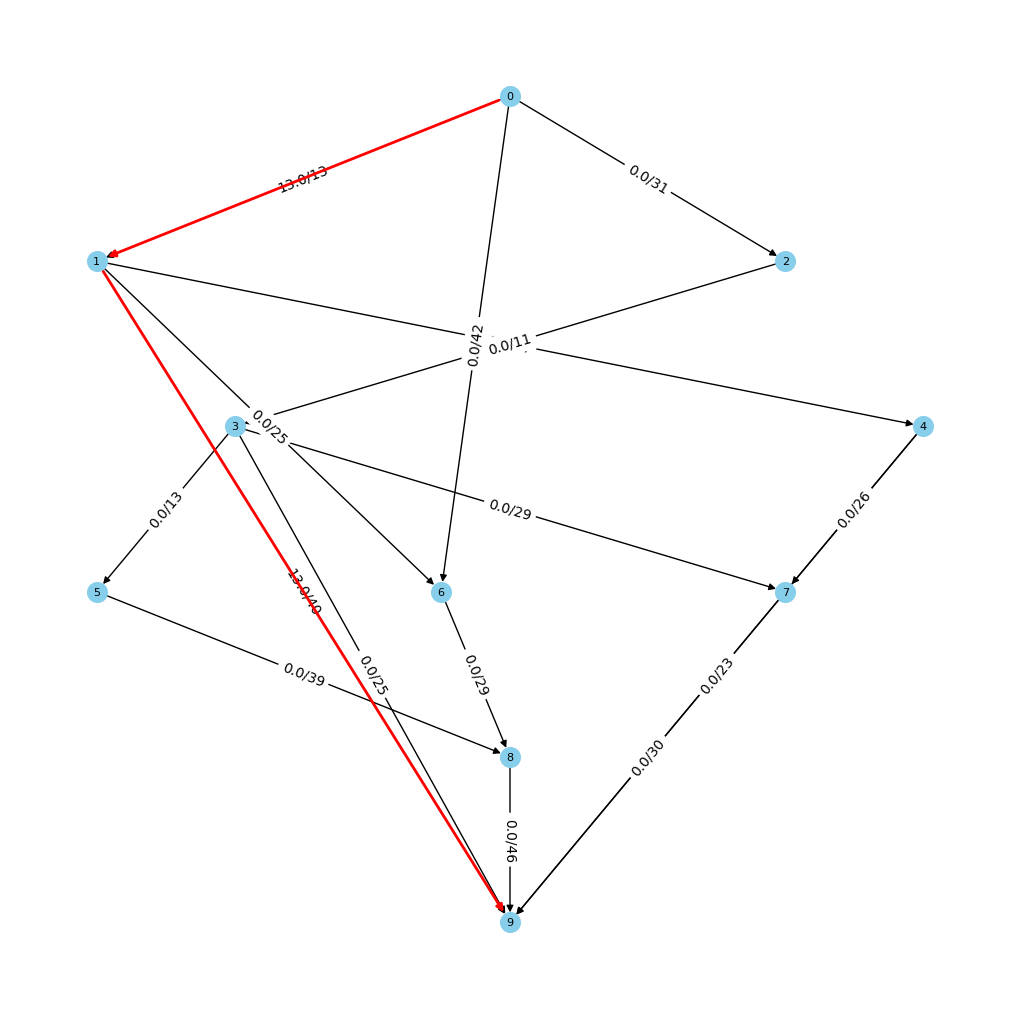

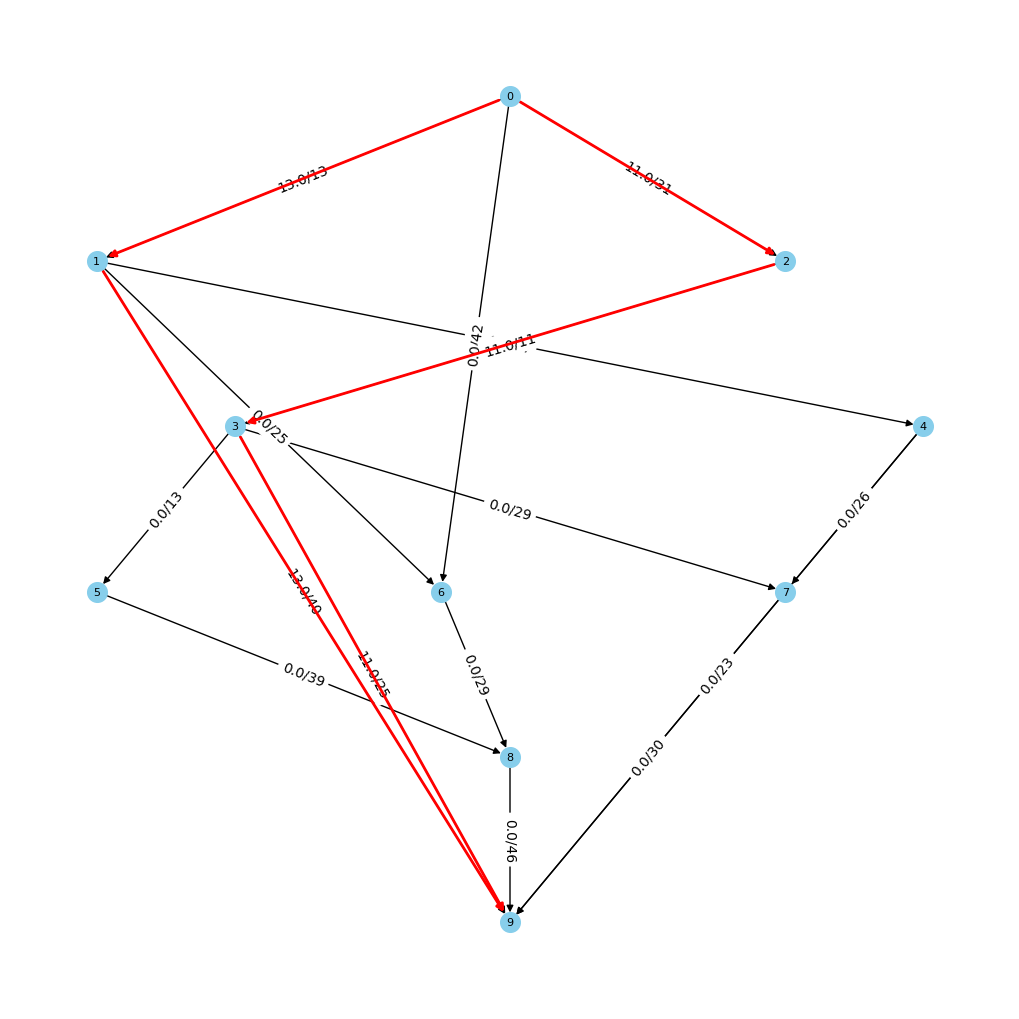

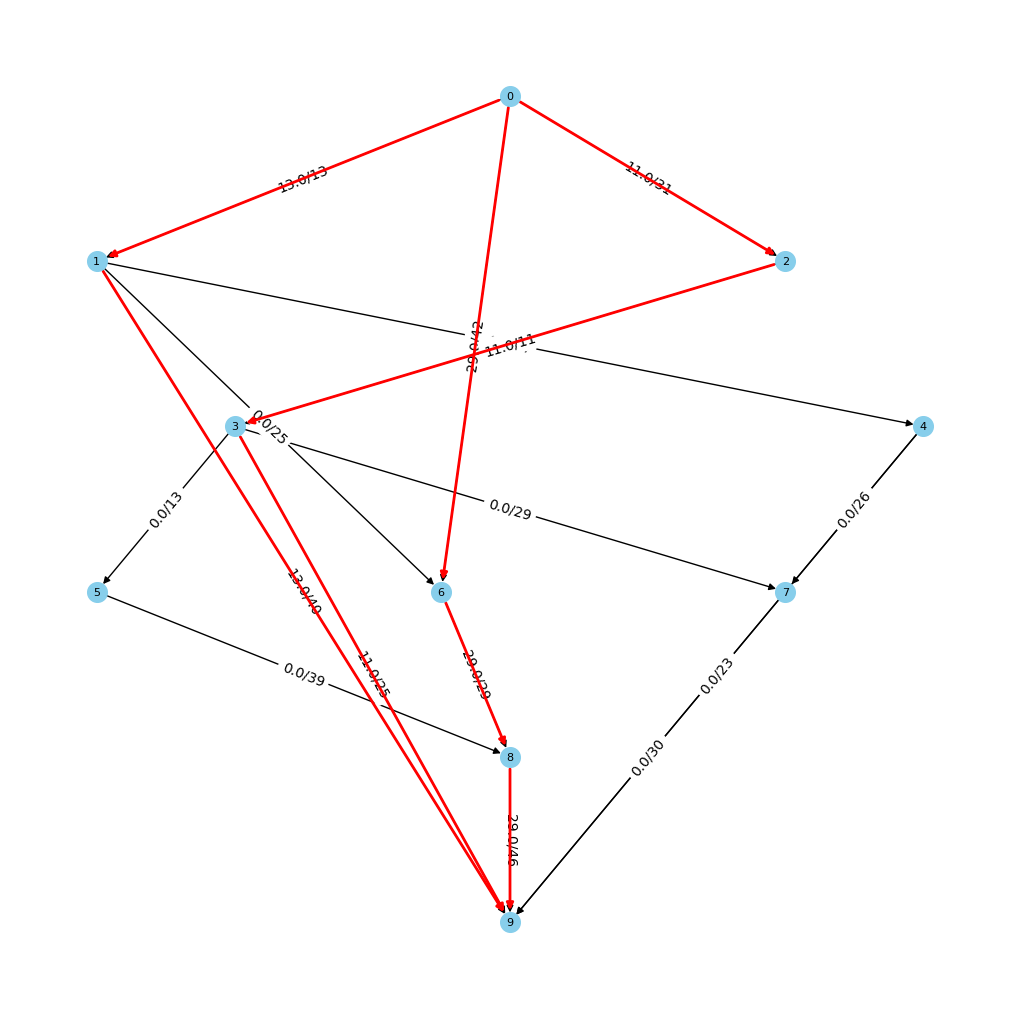

In [573]:
start = time()
max_flow, simulate_data = Dinic(adjacency_matrix, simulate=True)
run_time = time() - start
print(f"Dinic found max flow: {max_flow} with time {run_time}")
simulate_dinic(graph, pos, simulate_data, width, height)

Ford_Fulkerson found max flow: 53.0 with time 0.0009241104125976562


/tmp/ipykernel_32394/3642342988.py:76: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos, edgelist=[(data[i], data[i+1]) for i in range(len(data)-2)], edge_color='red', width=2)


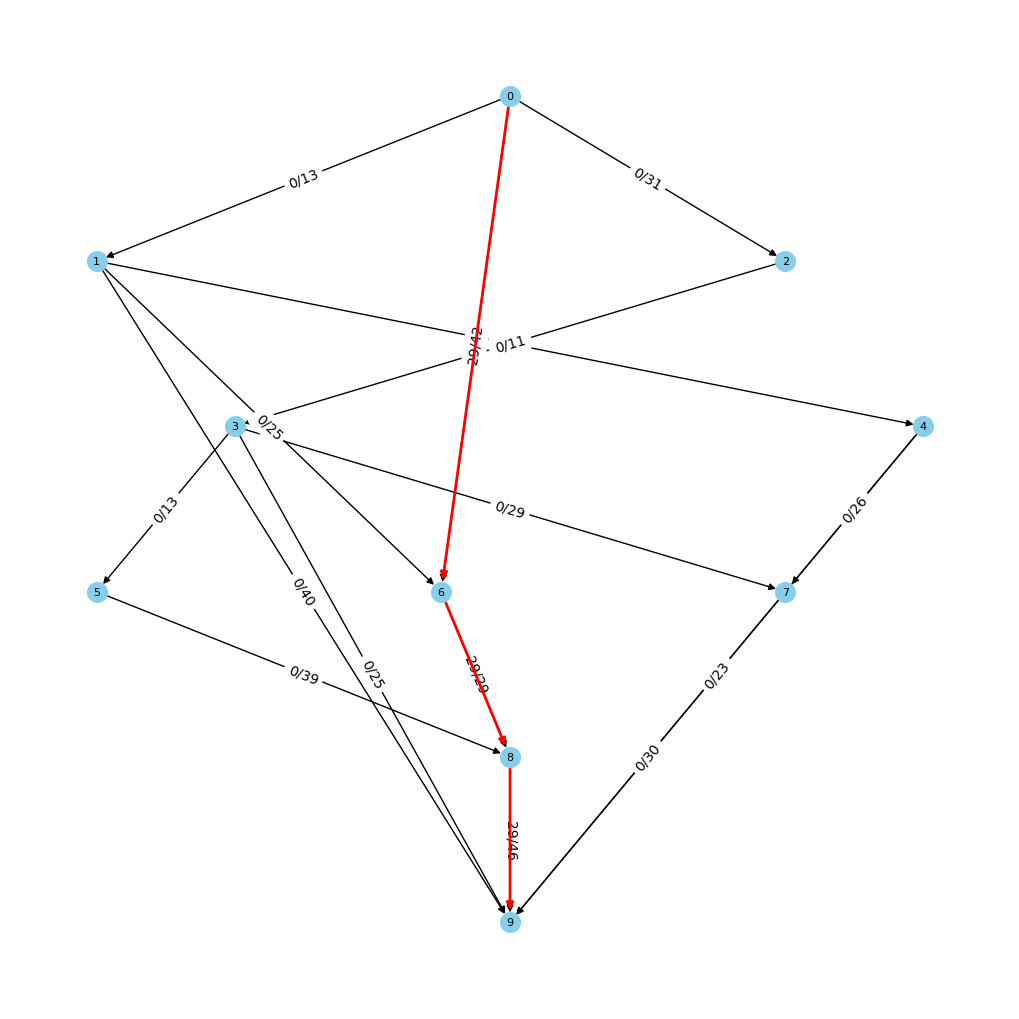

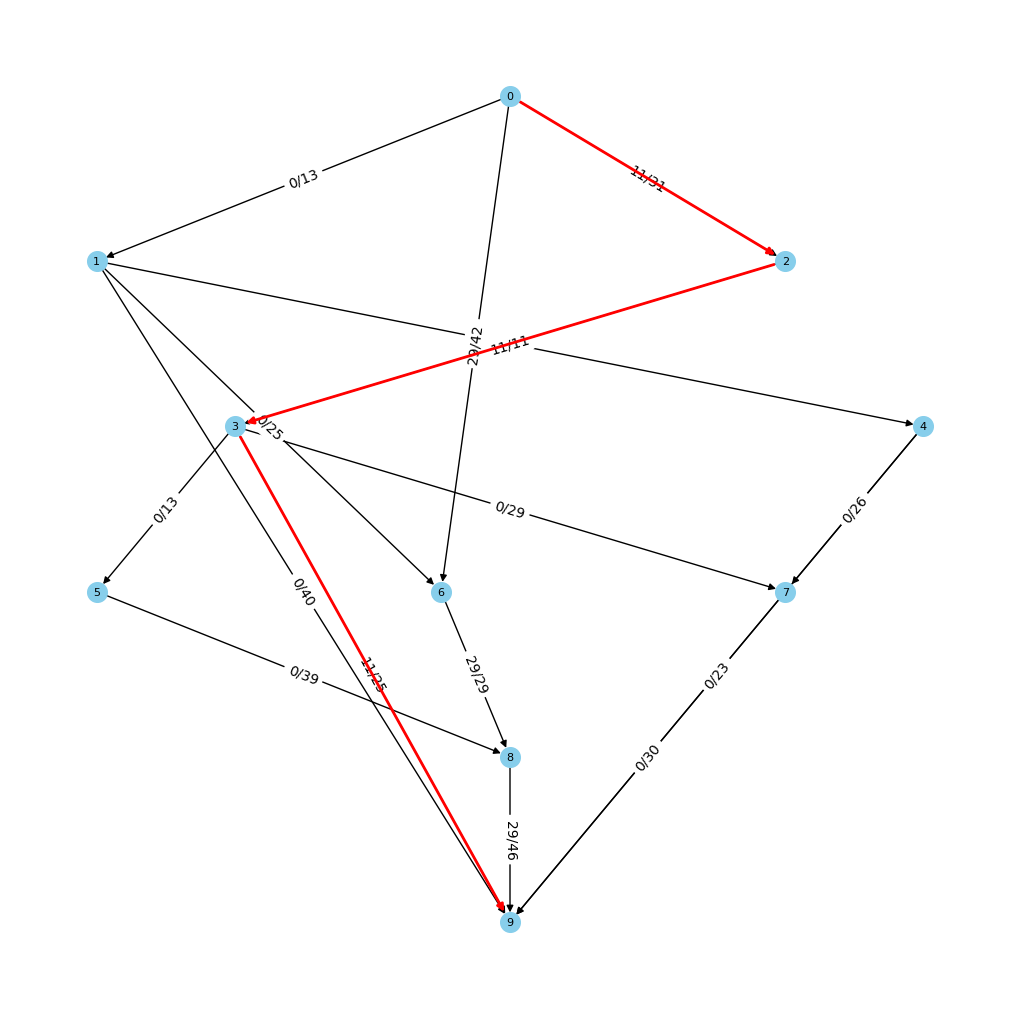

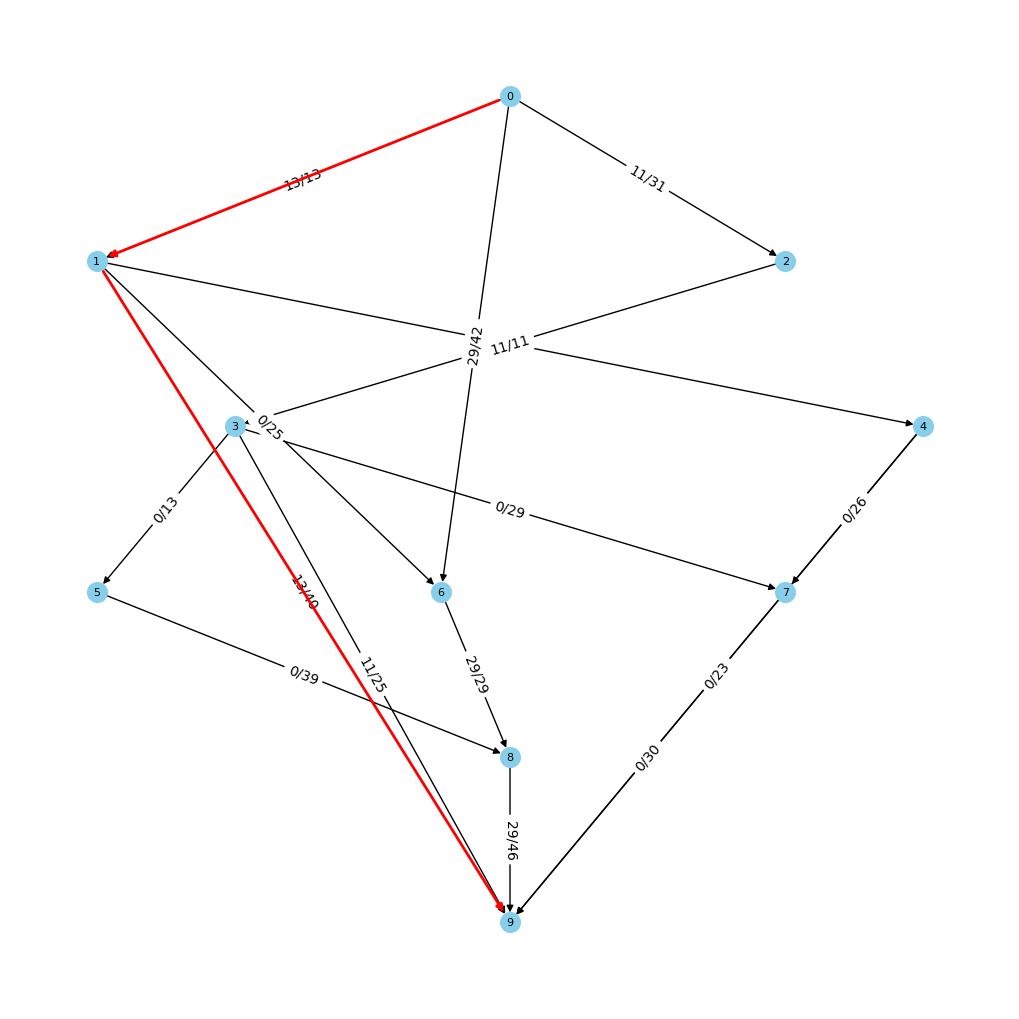

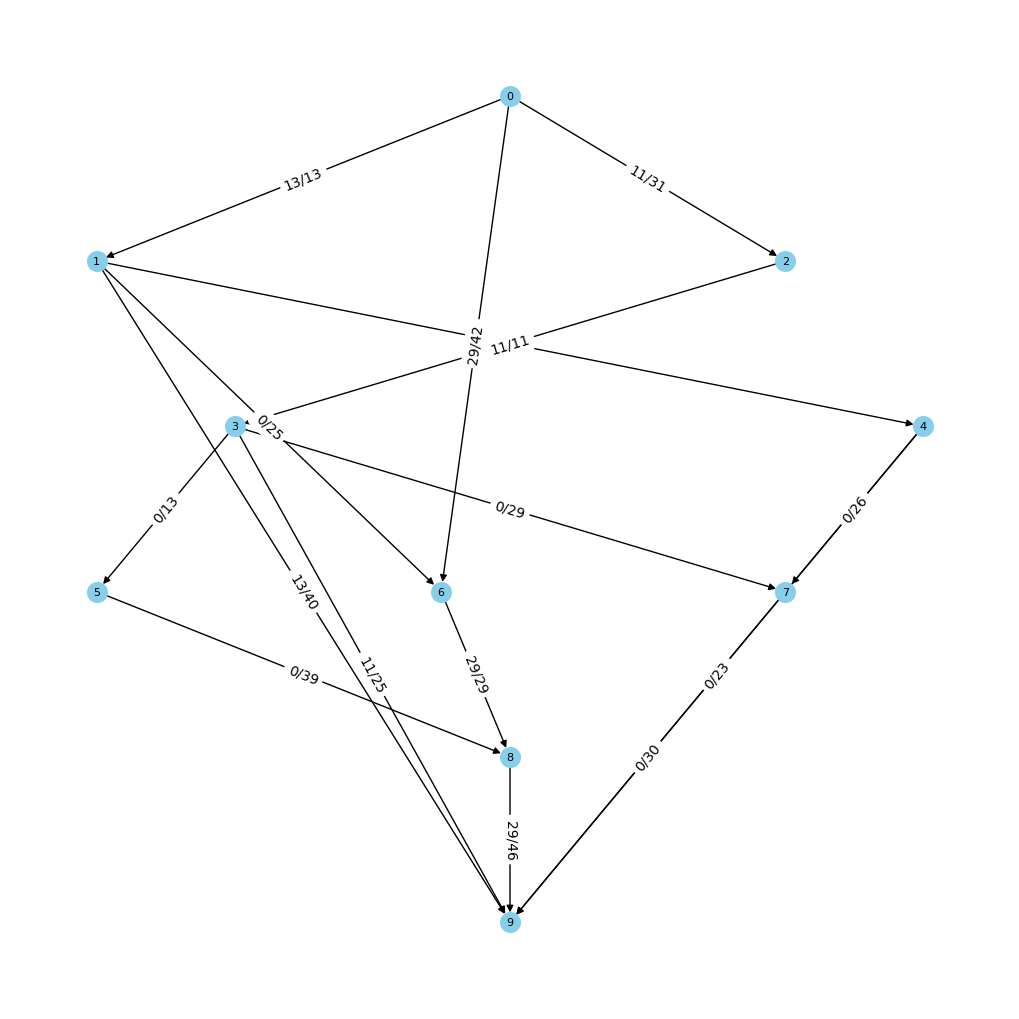

In [574]:
start = time()
max_flow, simulate_data = Ford_Fulkerson(adjacency_matrix, simulate=True)
run_time = time() - start
print(f"Ford_Fulkerson found max flow: {max_flow} with time {run_time}")
simulate_data
simulate(graph, pos, simulate_data, width, height)

EdmondKarp found max flow: 53.0 with time 0.0008907318115234375


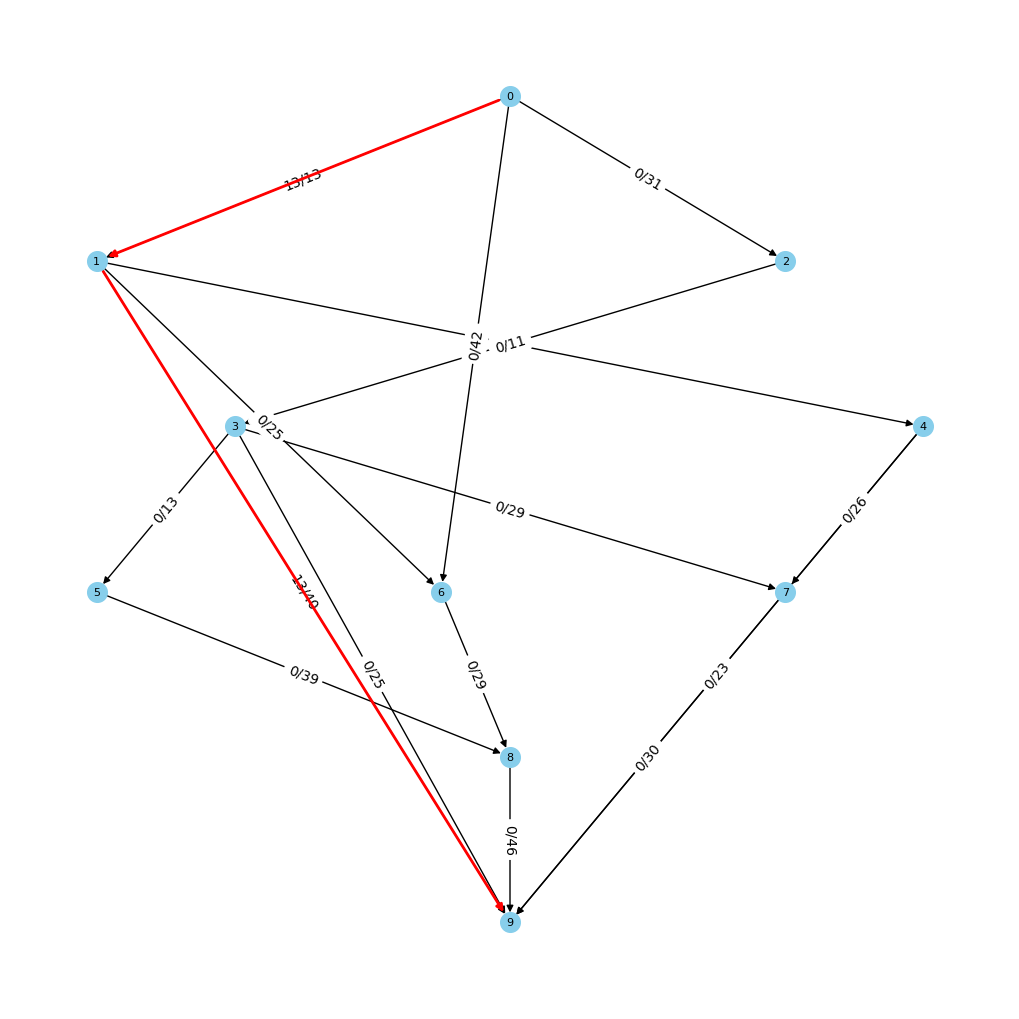

/tmp/ipykernel_32394/3642342988.py:76: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos, edgelist=[(data[i], data[i+1]) for i in range(len(data)-2)], edge_color='red', width=2)


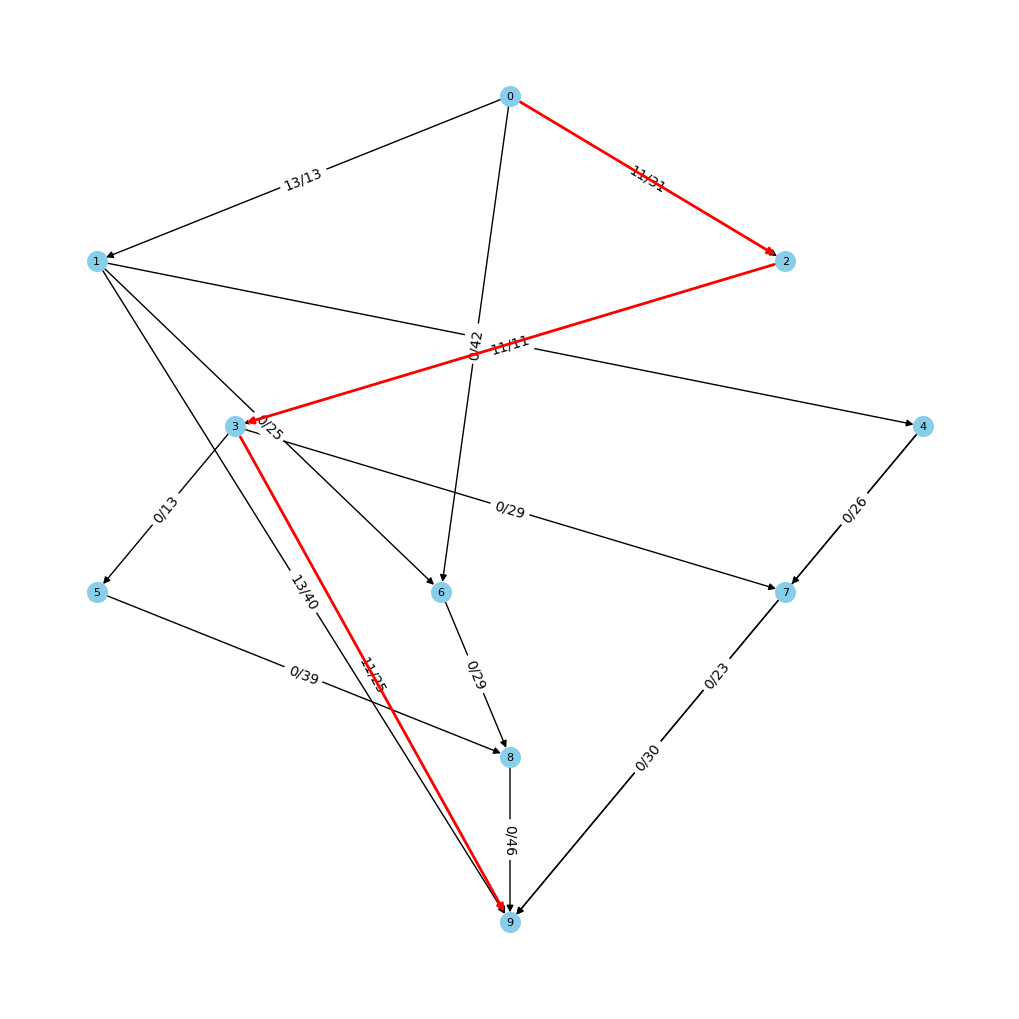

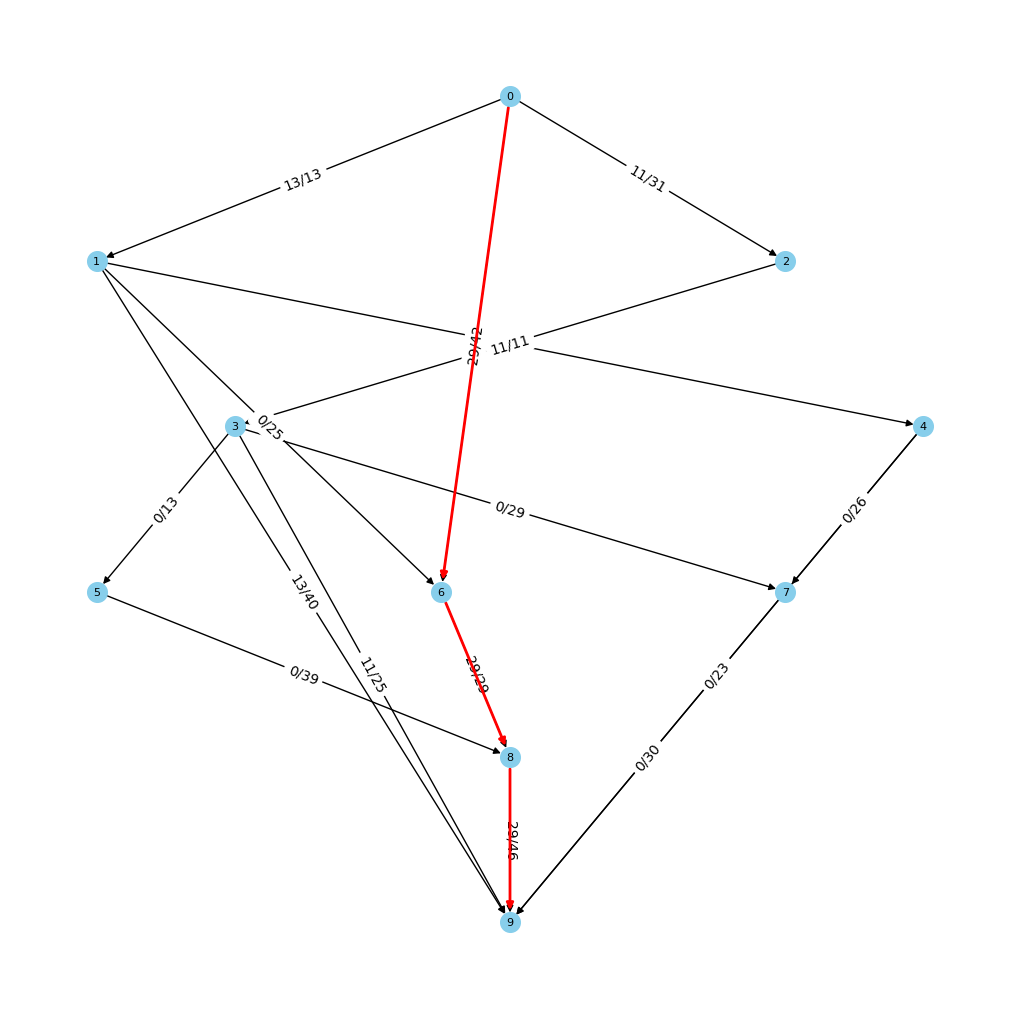

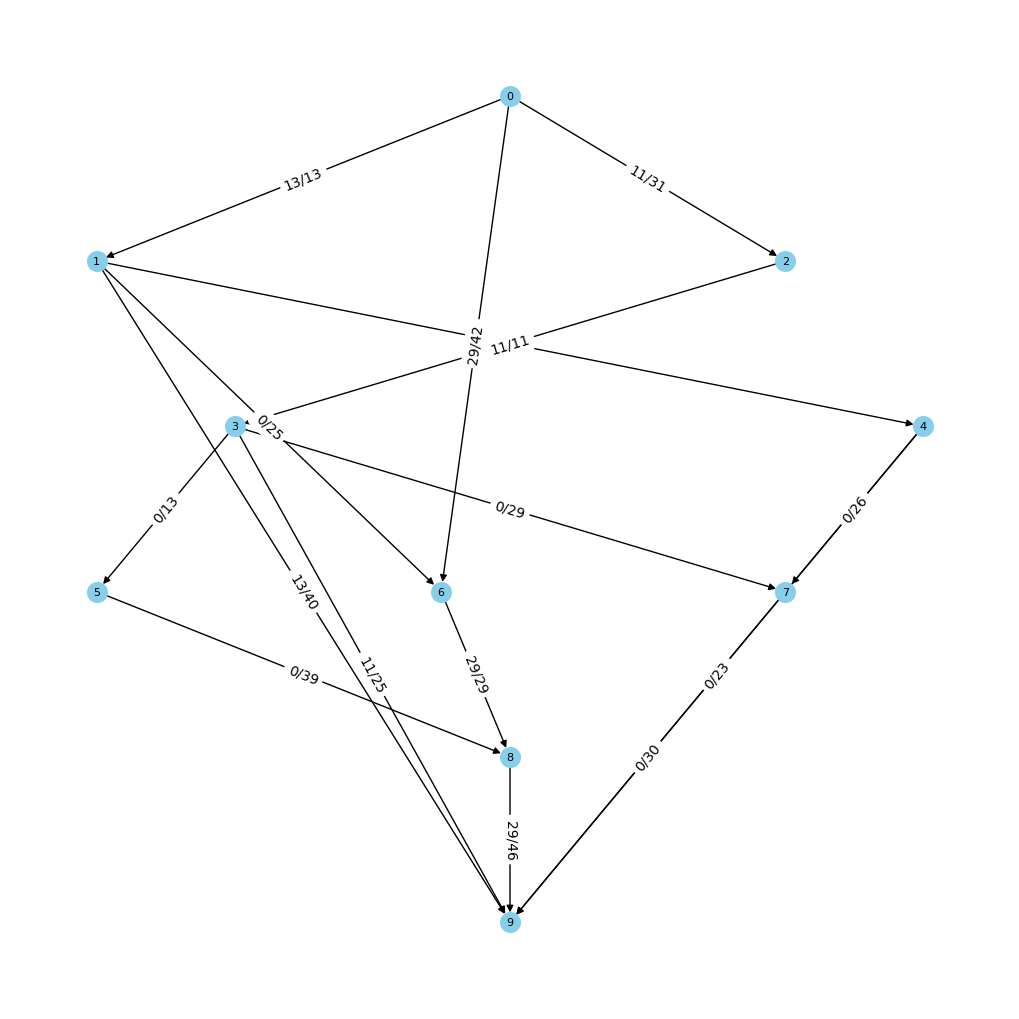

In [575]:
start = time()
max_flow, simulate_data = EdmondKarp(adjacency_matrix, simulate=True)
run_time = time() - start
print(f"EdmondKarp found max flow: {max_flow} with time {run_time}")
simulate_data
simulate(graph, pos, simulate_data, width, height)

In [375]:
print(repr(adjacency_matrix), file=open('sample_data.txt', 'w'))